In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
wnl = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(max_features=5000)
from sklearn.metrics import accuracy_score

In [106]:
df = pd.read_csv('./spam_dataset/spam.csv',encoding='latin-1')

In [107]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [108]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [109]:
df.rename(columns={'v1':'Target','v2':'Message'},inplace=True)

In [110]:
df.head()

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### BASIC EDA

In [13]:
df['Target'].value_counts()

Target
ham     4825
spam     747
Name: count, dtype: int64

We could get that this is biased dataset

<Axes: xlabel='Target', ylabel='count'>

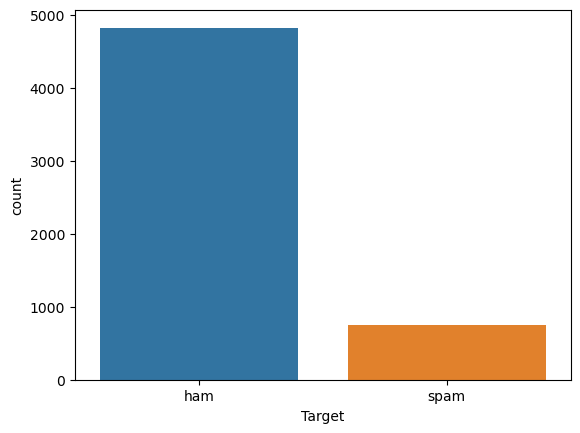

In [14]:
sns.countplot(data=df,x='Target')

## Preprocessing

In [97]:
df.isnull().sum()

Target     0
Message    0
dtype: int64

In [80]:
df.duplicated().sum()

403

In [111]:
df.drop_duplicates(inplace=True)

In [112]:
df.reset_index(drop=True,inplace=True)

In [113]:
df['Target_Encoded'] = label_encoder.fit_transform(df['Target'])

In [114]:
df_pr = df.copy()

In [115]:
df['Message'] = df['Message'].apply(lambda x: x.lower())

In [117]:
def preprocessing(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [wnl.lemmatize(i) for i in tokens if i not in stopwords.words('english')]
    lemmatized_text = ' '.join(lemmatized_tokens)
    pattern = r'[^\w\s]'
    clean_text = re.sub(pattern, '', lemmatized_text)
    return clean_text

In [120]:
df['Message'] = df['Message'].apply(lambda x: preprocessing(x))

### Splitting

In [123]:
X = df['Message']
y = df['Target_Encoded']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### vectorizing

In [129]:
vect_X_train = vectorizer.fit_transform(X_train)
vect_X_test  = vectorizer.transform(X_test)

In [138]:
vect_X_train = pd.DataFrame(vect_X_train.toarray())
vect_X_test  = pd.DataFrame(vect_X_test.toarray())

### Model Training

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [160]:
algo = {
    "logistic regression":LogisticRegression(max_iter=1000),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "MultinomialNB":MultinomialNB() 
}

In [167]:
predicted_scores = {}
for key,alg in tqdm(algo.items()):
    alg.fit(vect_X_train,y_train)
    y_pred = alg.predict(vect_X_train)
    train_score = accuracy_score(y_train,y_pred)
    y_pred = alg.predict(vect_X_test)
    test_score = accuracy_score(y_test,y_pred)
    predicted_scores[key] = {
        "train score":train_score,
        "test score":test_score
    }
    #predicted_scores['algo'] = key
    #predicted_scores['train'] = train_score
    #predicted_scores['test'] = test_score
    print(f"{key} completed")

 25%|█████████████████████                                                               | 1/4 [00:01<00:04,  1.46s/it]

logistic regression completed


 50%|██████████████████████████████████████████                                          | 2/4 [00:21<00:24, 12.17s/it]

DecisionTreeClassifier completed


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:51<00:20, 20.37s/it]

RandomForestClassifier completed


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.93s/it]

MultinomialNB completed


In [177]:
for algo in predicted_scores.items():
    name,scores = algo
    train = scores['train score']
    test = scores['test score']
    print(f"{name}:\ntrain: {train}\ntest: {test}\n\n")

logistic regression:
train: 0.9604389257868899
test: 0.9536928487690504


DecisionTreeClassifier:
train: 1.0
test: 0.9501758499413834


RandomForestClassifier:
train: 1.0
test: 0.9654161781946072


MultinomialNB:
train: 0.976609875830205
test: 0.958968347010551




RandomForestClassifier: 0.9718640093786636 - highest accuracy
but its overfitting so we go for MultinomialNB

In [155]:
mnb = MultinomialNB()

In [156]:
mnb.fit(vect_X_train,y_train)

MultinomialNB()

### Predicting

In [194]:
corpus = input("Enter the message\n")
corpus = corpus.lower()
corpus_pr = preprocessing(corpus)
vector = vectorizer.transform([corpus_pr])
pred = mnb.predict(pd.DataFrame(vector.toarray()))
pred = label_encoder.inverse_transform(pred)[0]
print(f"\nThe entered message is predicted as: {pred}")

Enter the message
 Congratulations! You’ve won a $500 Amazon gift card. Claim it here


The entered message is predicted as: spam
